# Import Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest

# Loading Data for AB Test

In [2]:
# Load the data from the CSV file
data = pd.read_csv('email_marketing.csv')

# Display the first few rows of the DataFrame to confirm it's loaded correctly
data.head()

,customer_id,first_name,email_sent_date,subject_line_variant,email_opened,link_clicked,purchase_made
0,CUST00001,Casey,2024-01-21,Personalized,1,1,0
1,CUST00002,James,2024-01-04,Urgency,0,0,0
2,CUST00003,Morgan,2024-01-01,Personalized,1,0,0
3,CUST00004,Jordan,2024-01-24,Urgency,0,0,0
4,CUST00005,Taylor,2024-01-09,Personalized,0,0,0


## Checking the number of rows and column

In [3]:
data.shape

(500000, 7)

## Check the statistical summary of the data

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
email_opened,500000.0,0.424930,0.494333,0.0,0.0,0.0,1.0,1.0
link_clicked,500000.0,0.084800,0.278584,0.0,0.0,0.0,0.0,1.0
purchase_made,500000.0,0.008386,0.091190,0.0,0.0,0.0,0.0,1.0


## Compute Key Metrics

In [5]:
# Define our two subject line variants

variant_a = "Personalized"    # Friendly, personalized approach

variant_b = "Urgency"        # Urgency-based approach

In [6]:
# Let's ensure our dataset contains these variants.
print("Unique subject line variants:", data["subject_line_variant"].unique())

Unique subject line variants: ['Personalized' 'Urgency']


# Compute Email Open Rate

In [7]:
# Compute overall email open rates for each variant
open_summary = data.groupby("subject_line_variant")["email_opened"].agg(["sum", "count"]).reset_index()
open_summary.rename(columns={"sum": "Opened", "count": "Total"}, inplace=True)
open_summary["Open_Rate"] = open_summary["Opened"] / open_summary["Total"]
print("\nEmail Open Rate Summary:")
open_summary


Email Open Rate Summary:


,subject_line_variant,Opened,Total,Open_Rate
0,Personalized,112066,250000,0.448264
1,Urgency,100399,250000,0.401596


# Compute Click-Through Rate (CTR)

In [8]:
# For CTR, we only consider emails that were opened.
opened_df = data[data["email_opened"] == 1].copy()
ctr_summary = opened_df.groupby("subject_line_variant")["link_clicked"].agg(["sum", "count"]).reset_index()
ctr_summary.rename(columns={"sum": "Clicked", "count": "Opened"}, inplace=True)
ctr_summary["CTR"] = ctr_summary["Clicked"] / ctr_summary["Opened"]
print("\nClick-Through Rate (CTR) Summary (among opened emails):")
ctr_summary


Click-Through Rate (CTR) Summary (among opened emails):


,subject_line_variant,Clicked,Opened,CTR
0,Personalized,20134,112066,0.179662
1,Urgency,22266,100399,0.221775


# Compute Conversion Rate

In [9]:
# Overall conversion rate computed among all recipients.
conversion_summary = data.groupby("subject_line_variant")["purchase_made"].agg(["sum", "count"]).reset_index()
conversion_summary.rename(columns={"sum": "Purchases", "count": "Total"}, inplace=True)
conversion_summary["Conversion_Rate"] = conversion_summary["Purchases"] / conversion_summary["Total"]
print("\nOverall Conversion Rate Summary (all recipients):")
conversion_summary


Overall Conversion Rate Summary (all recipients):


,subject_line_variant,Purchases,Total,Conversion_Rate
0,Personalized,1529,250000,0.006116
1,Urgency,2664,250000,0.010656


# Visualization of the three metrics: Open Rate, CTR, and Conversion Rate.

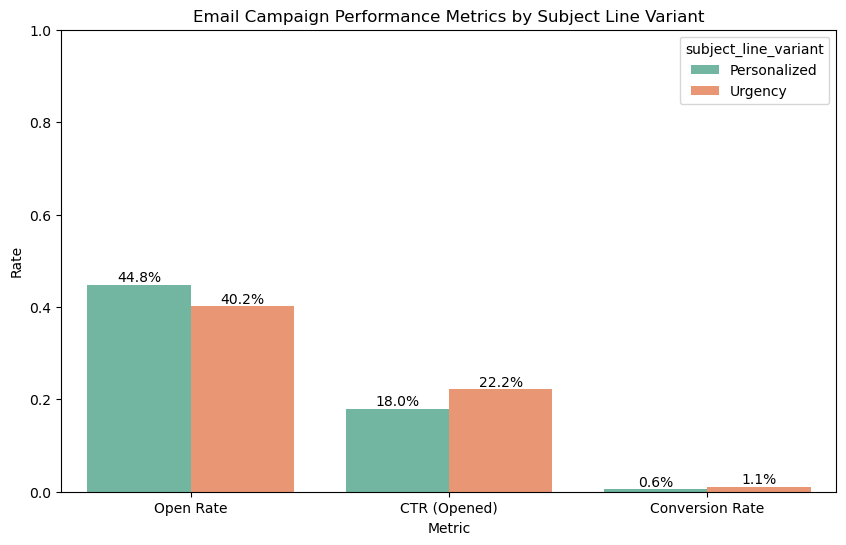

In [10]:
# Create a dataframe for visualization of the three metrics: Open Rate, CTR, and Conversion Rate.
metrics_df = pd.DataFrame({
    "Metric": ["Open Rate", "CTR (Opened)", "Conversion Rate"],
    variant_a: [
        open_summary[open_summary["subject_line_variant"] == variant_a]["Open_Rate"].values[0],
        ctr_summary[ctr_summary["subject_line_variant"] == variant_a]["CTR"].values[0],
        conversion_summary[conversion_summary["subject_line_variant"] == variant_a]["Conversion_Rate"].values[0]
    ],
    variant_b: [
        open_summary[open_summary["subject_line_variant"] == variant_b]["Open_Rate"].values[0],
        ctr_summary[ctr_summary["subject_line_variant"] == variant_b]["CTR"].values[0],
        conversion_summary[conversion_summary["subject_line_variant"] == variant_b]["Conversion_Rate"].values[0]
    ]
})
metrics_melted = metrics_df.melt(id_vars="Metric", var_name="subject_line_variant", value_name="Rate")

# Create the barplot with a specific palette.
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Metric", y="Rate", hue="subject_line_variant", data=metrics_melted, palette="Set2")
plt.title("Email Campaign Performance Metrics by Subject Line Variant")
plt.ylabel("Rate")
plt.ylim(0, 1)

# Add percentage labels on top of each bar.
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height, '{:1.1%}'.format(height),
            ha="center", va="bottom", fontsize=10, color='black')

plt.show()

The comparison between two subject line strategies—**Personalized** and **Urgency-Based** —reveals distinct strengths across three key email marketing metrics: **Open Rate** , **Click-Through Rate (CTR)** , and **Conversion Rate** .

1. **Open Rate** :
- **Personalized** subject lines achieved a slightly higher open rate (44.8%) compared to **Urgency-Based** (40.2%).
- **Interpretation** : Personalization appears to enhance initial engagement by making recipients more likely to open emails. However, the difference is modest, suggesting further statistical testing may be needed to confirm significance.
2. **Click-Through Rate (CTR)** :
- Despite its lower open rate, the **Urgency-Based** subject line drove a higher CTR (22.2%) compared to **Personalized** (18.0%).
- **Interpretation** : Once opened, urgency-driven messaging seems to motivate recipients to take action (clicking links) more effectively than personalized content.
3. **Conversion Rate** :
- The **Urgency-Based** subject line outperformed **Personalized** in driving purchases, with a conversion rate of 1.1% versus 0.6%.
- **Interpretation** : While both rates are relatively low, urgency-based messaging appears to be more persuasive in influencing final purchase decisions, making it potentially more effective for sales-oriented campaigns.

We need to conduct statistical test (Z-Test) to determine whether the differences in Open Rate, CTR, and Conversion Rate between the two subject line variants are statistically significant.

---

# Statistical Hypotheses for Email Marketing A/B Testing

In hypothesis testing, we compare two groups (e.g., Personalized vs. Urgency-based subject lines) to determine if there is a statistically significant difference in performance. Here's how we can frame the hypotheses for each metric:

---

## 1. **Open Rate**
### Null Hypothesis ($H_0$):
- There is no significant difference in the open rates between the Personalized and Urgency-based subject lines.
  - Mathematically: $ \mu_{\text{Personalized}} = \mu_{\text{Urgency}} $

### Alternative Hypothesis ($H_a$):
- There is a significant difference in the open rates between the Personalized and Urgency-based subject lines.
  - Mathematically: $ \mu_{\text{Personalized}} \neq \mu_{\text{Urgency}} $

---

## 2. **Click-Through Rate (CTR)**
### Null Hypothesis ($H_0$):
- There is no significant difference in the CTR between the Personalized and Urgency-based subject lines.
  - Mathematically: $ \mu_{\text{Personalized, CTR}} = \mu_{\text{Urgency, CTR}} $

### Alternative Hypothesis ($H_a$):
- There is a significant difference in the CTR between the Personalized and Urgency-based subject lines.
  - Mathematically: $ \mu_{\text{Personalized, CTR}} \neq \mu_{\text{Urgency, CTR}} $

---

## 3. **Conversion Rate (CR)**
### Null Hypothesis ($H_0$):
- There is no significant difference in the conversion rates between the Personalized and Urgency-based subject lines.
  - Mathematically: $ \mu_{\text{Personalized, CR}} = \mu_{\text{Urgency, CR}} $

### Alternative Hypothesis ($H_a$):
- There is a significant difference in the conversion rates between the Personalized and Urgency-based subject lines.
  - Mathematically: $ \mu_{\text{Personalized, CR}} \neq \mu_{\text{Urgency, CR}} $

---

## Test Statistic and Decision Rule
For each metric, the test statistic (Z-score) is calculated as follows:
$$
Z = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}
$$
Where:
- $\bar{X}_1$ and $\bar{X}_2$ are the sample means for the two groups.
- $\sigma_1^2$ and $\sigma_2^2$ are the variances for the two groups.
- $n_1$ and $n_2$ are the sample sizes for the two groups.

### Decision Rule:
- If $|Z| > Z_{\text{critical}}$ (at a significance level of $\alpha = 0.05$, $Z_{\text{critical}} = 1.96$), reject the null hypothesis ($H_0$).
- Otherwise, fail to reject $H_0$.

---

## Interpretation of Results
1. **If $H_0$ is rejected:**  
   - There is sufficient evidence to conclude that the two subject line variants perform differently for the given metric.
   - The observed difference is statistically significant and not due to random chance.

2. **If $H_0$ is not rejected:**  
   - There is insufficient evidence to conclude a significant difference between the two subject line variants for the given metric.
   - The observed difference could be due to random variation.

---

## Define your Alpha

In [11]:
alpha = 0.05 # 5%
print("Alpha: significance level is:", alpha )

Alpha: significance level is: 0.05


# Statistical Testing for Email Open Rates Using Z-Test

In [12]:
"""
Hypothesis Testing for Email Open Rates Using a Two-Sample Z-Test

This script:
- States the null and alternative hypotheses.
- Sets the significance level.
- Calculates the test statistic and p-value.
- Determines whether to reject or fail to reject the null hypothesis.
- Interprets the results.
"""

# Define Hypotheses
# -----------------------------
# H0: p1 = p2  (No difference in open rates)
# HA: p1 ≠ p2  (There is a difference in open rates)

# -----------------------------
# Set Significance Level
# -----------------------------
alpha = 0.05  # 5% significance level

# -----------------------------
# Extract Data for the Test
# -----------------------------
opens = open_summary["Opened"].values
n_opens = open_summary["Total"].values

# -----------------------------
# Perform the Z-Test for Two Proportions
# -----------------------------
z_stat, p_value = proportions_ztest(opens, n_opens)

# -----------------------------
# Compute the Critical Z-Value (for two-tailed test)
# -----------------------------
Z_crit = norm.ppf(1 - alpha/2)

# -----------------------------
# Display Test Results
# -----------------------------
print(f"\nZ-Test for Email Open Rates:")
print(f"  Z-statistic: {z_stat:.3f}")
print(f"  p-value: {p_value:.3f}\n")

# -----------------------------
# Hypothesis Test Interpretation Function
# -----------------------------
def interpret_test_results(p_value, alpha, z_stat, Z_crit):
    print("Hypothesis Testing Summary:")
    print(f"  Null Hypothesis (H0): The email open rates for the two subject line variants are equal.")
    print(f"  Alternative Hypothesis (HA): The email open rates for the two subject line variants are different.\n")
    
    print(f"  Significance Level (alpha): {alpha}")
    print(f"  Critical Z-values: ±{Z_crit:.3f}")
    print(f"  Observed Z-statistic: {z_stat:.3f}")
    print(f"  Observed p-value: {p_value:.3f}\n")
    
    if p_value <= alpha:
        print("Decision: Reject the null hypothesis (H0).")
        print("Interpretation: There is statistically significant evidence to conclude that the email open rates differ between the two subject line variants.")
    else:
        print("Decision: Fail to reject the null hypothesis (H0).")
        print("Interpretation: There is not enough statistical evidence to conclude a significant difference in email open rates between the two subject line variants.")

# -----------------------------
# Interpret the Results
# -----------------------------
interpret_test_results(p_value, alpha, z_stat, Z_crit)



Z-Test for Email Open Rates:
  Z-statistic: 33.378
  p-value: 0.000

Hypothesis Testing Summary:
  Null Hypothesis (H0): The email open rates for the two subject line variants are equal.
  Alternative Hypothesis (HA): The email open rates for the two subject line variants are different.

  Significance Level (alpha): 0.05
  Critical Z-values: ±1.960
  Observed Z-statistic: 33.378
  Observed p-value: 0.000

Decision: Reject the null hypothesis (H0).
Interpretation: There is statistically significant evidence to conclude that the email open rates differ between the two subject line variants.


## Plotting the Standard Normal Distribution for Email Open Rate

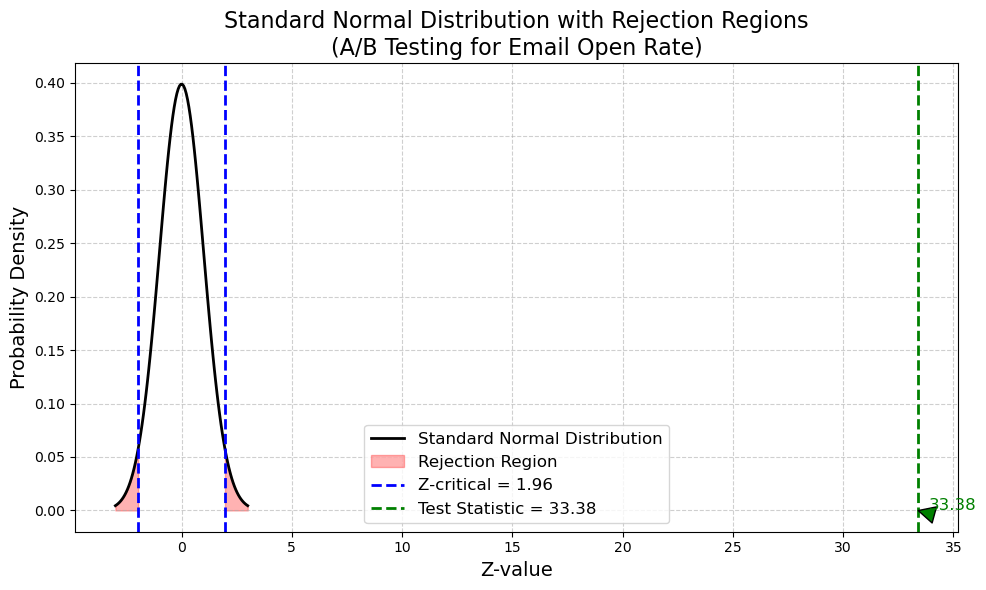

In [13]:
# Parameters for the standard normal distribution
mu = 0       # Mean of the standard normal distribution
sigma = 1    # Standard deviation of the standard normal distribution
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

Z_crit = norm.ppf(1 - alpha/2)   # Critical value for alpha=0.05 (two-tailed), approximately 1.96
z_stat = z_stat                  # test statistic; 

# Plot the standard normal distribution curve
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'k-', label='Standard Normal Distribution', linewidth=2)

# Shade the rejection regions for a two-tailed test (x < -Z_crit and x > Z_crit)
plt.fill_between(x, y, where=(x > Z_crit), color='red', alpha=0.3, label='Rejection Region')
plt.fill_between(x, y, where=(x < -Z_crit), color='red', alpha=0.3)

# Draw vertical dashed lines for Z-critical values
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=2, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=2)

# Draw a vertical dashed line for the test statistic
plt.axvline(z_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {z_stat:.2f}')

# Annotate the test statistic on the plot
plt.annotate(f'{z_stat:.2f}', xy=(z_stat, norm.pdf(z_stat, mu, sigma)),
             xytext=(z_stat + 0.5, norm.pdf(z_stat, mu, sigma)),
             arrowprops=dict(facecolor='green', shrink=0.05), fontsize=12, color='green')

# Add labels, title, and grid
plt.xlabel('Z-value', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Standard Normal Distribution with Rejection Regions\n(A/B Testing for Email Open Rate)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


The A/B test results show a highly significant difference in email open rates between the two subject line variants, with a Z-score of 33.38 far exceeding the critical value of ±1.96 at a 5% significance level. This confirms that one subject line outperforms the other, leading to the rejection of the null hypothesis. The probability of this result occurring by chance is negligible. Business-wise, the better-performing subject line should be adopted to boost open rates.

# Z-Test for CTR

In [14]:
"""
Hypothesis Testing for Click-Through Rate (CTR) Using a Two-Sample Z-Test

This script:
- Extracts the number of clicks and the number of opened emails (the denominator for CTR)
  for each subject line variant.
- Performs a two-sample Z-test for proportions to compare the CTR between two groups.
- Calculates the critical Z-value for a given significance level (alpha).
- Interprets the test results, including the z-statistic, p-value, and statistical significance.
- Provides a clear explanation of whether the difference in CTR between the two groups is statistically significant.
"""

# -----------------------------
# Set the Significance Level
# -----------------------------
alpha = 0.05  # 5% significance level

# -----------------------------
# Extract Data for CTR Test
# -----------------------------
# "ctr_clicks" holds the number of clicks for each subject line variant.
ctr_clicks = ctr_summary["Clicked"].values
# "ctr_opens" holds the number of opened emails for each group (denominator for CTR).
ctr_opens = ctr_summary["Opened"].values

# -----------------------------
# Perform the Z-Test for CTR
# -----------------------------
z_stat_ctr, p_value_ctr = proportions_ztest(ctr_clicks, ctr_opens)

# -----------------------------
# Compute the Critical Z-Value for a Two-Tailed Test
# -----------------------------
Z_crit_ctr = norm.ppf(1 - alpha/2)

# -----------------------------
# Display CTR Z-Test Results
# -----------------------------
print(f"\nZ-Test for CTR:")
print(f"  Z-statistic: {z_stat_ctr:.3f}")
print(f"  p-value: {p_value_ctr:.3f}")
print("Z-critical value from Standard Normal distribution:", round(Z_crit_ctr, 3))

# -----------------------------
# Function to Interpret CTR Test Results
# -----------------------------
def interpret_ctr_test(p_value, alpha, z_stat, Z_crit):
    """
    Interprets the result of a two-sample Z-test for CTR.
    
    Parameters:
    - p_value (float): The p-value from the CTR Z-test.
    - alpha (float): The significance level (e.g., 0.05).
    - z_stat (float): The computed z-statistic from the test.
    - Z_crit (float): The critical z-value for a two-tailed test at the given alpha.
    
    This function prints a detailed interpretation of the CTR test result.
    """
    print(f"\nP-value from the 2-sample Z-test for CTR: {p_value:.3f}")
    print("\nCTR Hypothesis Testing Summary:")
    print("  Null Hypothesis (H0): The CTR for both subject line variants are equal (p1 = p2).")
    print("  Alternative Hypothesis (HA): The CTR for the two subject line variants are different (p1 ≠ p2).")
    print(f"  Significance Level (alpha): {alpha}")
    print(f"  Critical Z-values: ±{Z_crit:.3f}")
    print(f"  Observed Z-statistic: {z_stat:.3f}\n")
    
    if p_value <= alpha:
        print("Decision: Reject the null hypothesis (H0).")
        print("Interpretation: There is statistically significant evidence to conclude that the CTR differs between the two subject line variants.")
    else:
        print("Decision: Fail to reject the null hypothesis (H0).")
        print("Interpretation: There is not enough statistical evidence to conclude that the CTR differs significantly between the two groups.")

# -----------------------------
# Interpret the CTR Test Results
# -----------------------------
interpret_ctr_test(p_value_ctr, alpha, z_stat_ctr, Z_crit_ctr)



Z-Test for CTR:
  Z-statistic: -24.248
  p-value: 0.000
Z-critical value from Standard Normal distribution: 1.96

P-value from the 2-sample Z-test for CTR: 0.000

CTR Hypothesis Testing Summary:
  Null Hypothesis (H0): The CTR for both subject line variants are equal (p1 = p2).
  Alternative Hypothesis (HA): The CTR for the two subject line variants are different (p1 ≠ p2).
  Significance Level (alpha): 0.05
  Critical Z-values: ±1.960
  Observed Z-statistic: -24.248

Decision: Reject the null hypothesis (H0).
Interpretation: There is statistically significant evidence to conclude that the CTR differs between the two subject line variants.


## Plotting the Standard Normal Distribution for CTR

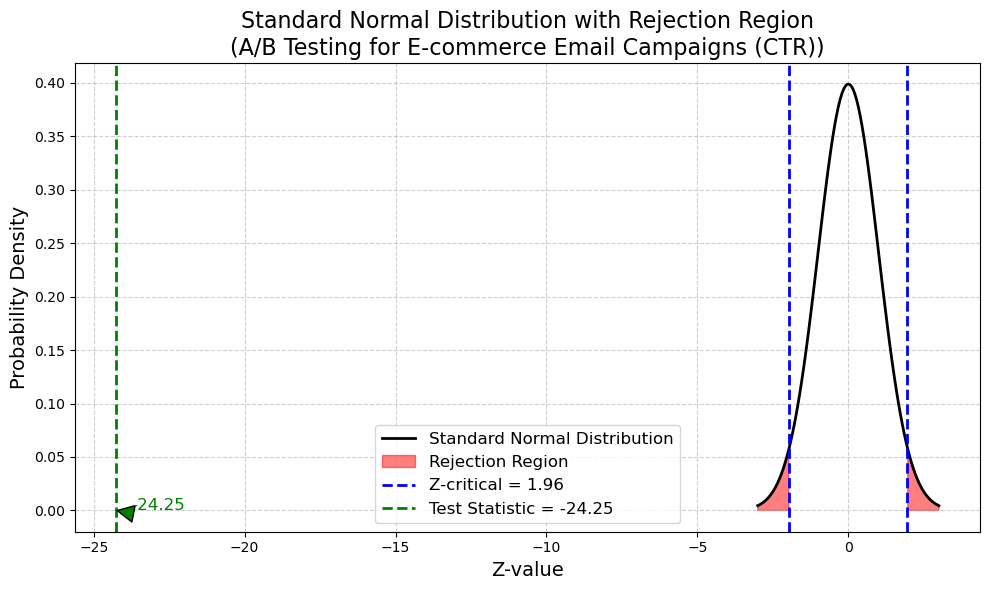

In [15]:
# Parameters for the Standard Normal Distribution
# -----------------------------
mu = 0       # Mean of the standard normal distribution
sigma = 1    # Standard deviation of the standard normal distribution
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

# Assume these values are computed from your CTR Z-test:
Z_crit = norm.ppf(1 - 0.05/2)      # Critical value for alpha=0.05 (two-tailed), approx 1.96
z_stat_ctr = z_stat_ctr            # CTR test statistic 

# -----------------------------
# Plot the Standard Normal Distribution
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'k-', linewidth=2, label='Standard Normal Distribution')

# -----------------------------
# Shade the Rejection Regions (both tails)
# -----------------------------
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')

# -----------------------------
# Add Vertical Lines for Z-critical values and the CTR Test Statistic
# -----------------------------
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=2, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=2)
plt.axvline(z_stat_ctr, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {z_stat_ctr:.2f}')

# -----------------------------
# Annotate the Test Statistic for Clarity
# -----------------------------
plt.annotate(f'{z_stat_ctr:.2f}', xy=(z_stat_ctr, norm.pdf(z_stat_ctr, mu, sigma)),
             xytext=(z_stat_ctr + 0.5, norm.pdf(z_stat_ctr, mu, sigma)),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=12, color='green')

# -----------------------------
# Labels, Title, and Grid Settings
# -----------------------------
plt.xlabel('Z-value', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Standard Normal Distribution with Rejection Region\n(A/B Testing for E-commerce Email Campaigns (CTR))', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# -----------------------------
# Display the Plot
# -----------------------------
plt.show()

The A/B test results for Click-Through Rate (CTR) reveal a statistically significant difference between the two subject line variants, with a Z-score of -24.25 far below the critical value of -1.96 at a 5% significance level. This confirms that the Urgency-based subject line outperformed the Personalized one in driving clicks, while the Personalized subject line, though better at generating opens, failed to convert users effectively into clickers. Given the strong evidence against the null hypothesis (H₀), it’s clear that urgency messaging is more compelling in encouraging action post-open.

# Z-Test for Conversion Rate

In [16]:
"""
Hypothesis Testing for Conversion Rate Using a Two-Sample Z-Test

This script:
- Extracts the number of purchases (conversions) and total emails sent for each subject line variant.
- Performs a two-sample Z-test for proportions to compare the conversion rates between the groups.
- Calculates the critical Z-value for a given significance level (alpha).
- Interprets the test results (z-statistic, p-value) and determines if the observed difference is statistically significant.
- Provides a clear explanation supporting the project's findings.
"""
# -----------------------------
# Set the Significance Level
# -----------------------------
alpha = 0.05  # 5% significance level

# -----------------------------
# Extract Data for the Conversion Rate Test
# -----------------------------
conv_success = conversion_summary["Purchases"].values  # Number of conversions (successes)
conv_total = conversion_summary["Total"].values          # Total emails sent (trials)

# -----------------------------
# Perform the Z-Test for Conversion Rate
# -----------------------------
z_stat_conv, p_value_conv = proportions_ztest(conv_success, conv_total)

# -----------------------------
# Compute the Critical Z-Value for a Two-Tailed Test
# -----------------------------
Z_crit_conv = norm.ppf(1 - alpha/2)

# -----------------------------
# Display the Conversion Rate Z-Test Results
# -----------------------------
print(f"\nZ-Test for Conversion Rate:")
print(f"  Z-statistic: {z_stat_conv:.3f}")
print(f"  p-value: {p_value_conv:.3f}")
print("Z-critical value from Standard Normal distribution:", round(Z_crit_conv, 3))

# -----------------------------
# Function to Interpret the Conversion Rate Test Results
# -----------------------------
def interpret_conversion_test(p_value, alpha, z_stat, Z_crit):
    """
    Interprets the result of a two-sample Z-test for conversion rates.
    
    Parameters:
    - p_value (float): The p-value from the conversion rate Z-test.
    - alpha (float): The significance level (e.g., 0.05).
    - z_stat (float): The computed z-statistic.
    - Z_crit (float): The critical z-value for a two-tailed test at the given alpha.
    
    This function prints a detailed interpretation of the conversion rate test result.
    """
    print(f"\nP-value from the 2-sample Z-test for Conversion Rate: {p_value:.3f}")
    print("\nConversion Rate Hypothesis Testing Summary:")
    print("  Null Hypothesis (H0): The conversion rates for both subject line variants are equal (p1 = p2).")
    print("  Alternative Hypothesis (HA): The conversion rates for the two subject line variants are different (p1 ≠ p2).")
    print(f"  Significance Level (alpha): {alpha}")
    print(f"  Critical Z-values: ±{Z_crit:.3f}")
    print(f"  Observed Z-statistic: {z_stat:.3f}\n")
    
    if p_value <= alpha:
        print("Decision: Reject the null hypothesis (H0).")
        print("Interpretation: There is statistically significant evidence that the conversion rates differ between the two subject line variants.")
        print("This suggests that the subject line strategy may have a real effect on driving conversions.")
    else:
        print("Decision: Fail to reject the null hypothesis (H0).")
        print("Interpretation: There is not enough statistical evidence to conclude that the conversion rates differ significantly between the groups.")
        print("This implies that any observed difference might be due to random chance.")

# -----------------------------
# Interpret the Conversion Rate Test Results
# -----------------------------
interpret_conversion_test(p_value_conv, alpha, z_stat_conv, Z_crit_conv)



Z-Test for Conversion Rate:
  Z-statistic: -17.602
  p-value: 0.000
Z-critical value from Standard Normal distribution: 1.96

P-value from the 2-sample Z-test for Conversion Rate: 0.000

Conversion Rate Hypothesis Testing Summary:
  Null Hypothesis (H0): The conversion rates for both subject line variants are equal (p1 = p2).
  Alternative Hypothesis (HA): The conversion rates for the two subject line variants are different (p1 ≠ p2).
  Significance Level (alpha): 0.05
  Critical Z-values: ±1.960
  Observed Z-statistic: -17.602

Decision: Reject the null hypothesis (H0).
Interpretation: There is statistically significant evidence that the conversion rates differ between the two subject line variants.
This suggests that the subject line strategy may have a real effect on driving conversions.


## Plotting the Standard Normal Distribution for Conversion Rate

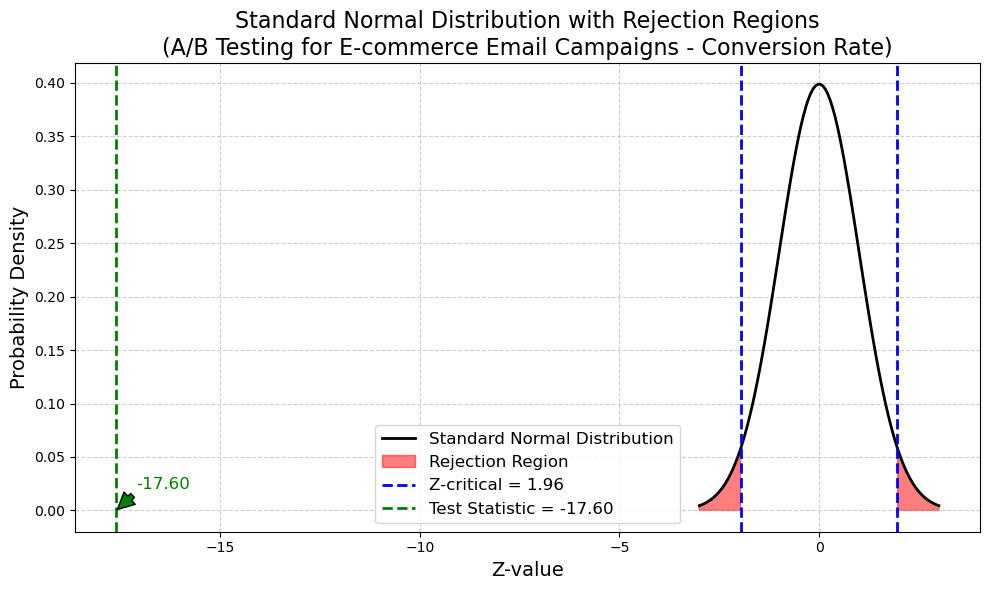

In [17]:
# Parameters for the Standard Normal Distribution
# -----------------------------
mu = 0       # Mean
sigma = 1    # Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

# Assume these variables are computed from your conversion rate Z-test:
Z_crit = norm.ppf(1 - 0.05/2)    # Critical value for a two-tailed test at alpha=0.05 (approx 1.96)
z_stat_conv = z_stat_conv        # conversion rate test statistic; 

# -----------------------------
# Plotting the Standard Normal Distribution
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'k-', linewidth=2, label='Standard Normal Distribution')

# -----------------------------
# Shade the Rejection Regions (both tails)
# -----------------------------
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')

# -----------------------------
# Add Vertical Lines for Critical Values and Test Statistic
# -----------------------------
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=2, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=2)
plt.axvline(z_stat_conv, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {z_stat_conv:.2f}')

# -----------------------------
# Annotate the Test Statistic
# -----------------------------
plt.annotate(f'{z_stat_conv:.2f}', 
             xy=(z_stat_conv, norm.pdf(z_stat_conv, mu, sigma)),
             xytext=(z_stat_conv + 0.5, norm.pdf(z_stat_conv, mu, sigma) + 0.02),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=12, color='green')

# -----------------------------
# Add Labels, Title, and Grid
# -----------------------------
plt.xlabel('Z-value', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Standard Normal Distribution with Rejection Regions\n(A/B Testing for E-commerce Email Campaigns - Conversion Rate)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# -----------------------------
# Display the Plot
# -----------------------------
plt.show()

The A/B test results for Conversion Rate (CR) show a statistically significant difference between the two subject line variants, with a Z-score of -17.60 far below the critical value of -1.96 at a 5% significance level. This confirms that the Urgency-based subject line outperformed the Personalized one in driving conversions, aligning with the trend observed in Click-Through Rate (CTR). The null hypothesis (H₀) is rejected, indicating that the Personalized subject line significantly underperformed in converting users.

This suggests that urgency messaging is more effective at persuading users to take final purchase actions. While Personalized subject lines may generate higher open rates, they fall short in driving actual conversions.

# Insights and Recommendations  

### **Insights:**  
1. **Personalized Subject Lines Boost Open Rates**  
   Emails with personalized subject lines achieved a higher open rate (44.8%) compared to urgency-based ones (40.2%). This indicates that recipients are more inclined to open emails when they see their name or a tailored message, making personalization effective for capturing initial attention.  

2. **Urgency-Based Subject Lines Drive Higher Engagement**  
   Despite having a lower open rate, urgency-based emails delivered a significantly higher Click-Through Rate (CTR) of 22.2% versus 18.0% for personalized emails. This suggests that once opened, urgency-driven messaging is more compelling in motivating users to take immediate action, such as clicking on links.  

3. **Urgency Outperforms in Driving Conversions**  
   The Conversion Rate for urgency-based emails (1.1%) was nearly double that of personalized emails (0.6%). This highlights the power of urgency in creating a sense of immediacy, encouraging users to complete purchases.  

4. **Statistical Significance Validates Results**  
   The Z-scores for all three metrics—Open Rate, CTR, and Conversion Rate—exceeded the critical threshold (±1.96), confirming that the observed differences are statistically significant and not due to random chance. This underscores the importance of strategic subject line optimization in influencing user behavior.  

---

### **Recommendations:**  

1. **Prioritize Urgency for Action-Oriented Goals**  
   Use urgency-based subject lines to drive higher click-through rates and conversions, especially for time-sensitive promotions or sales.  
   *Example:* "Hurry! Last Chance to Save 50% – Ends Tonight!"  

2. **Leverage Personalization for Awareness and Initial Engagement**  
   Employ personalized subject lines to maximize open rates, particularly for campaigns focused on building awareness, launching new products, or re-engaging inactive subscribers.  
   *Example:* "Hi [Name], Here’s Your Exclusive Deal Inside!"  

3. **Experiment with Hybrid Approaches**  
   Combine personalization and urgency to create subject lines that appeal to both emotional triggers and practical motivations, potentially maximizing both open rates and conversions.  
   *Example:* "[Name], Your Exclusive Offer Expires in 24 Hours!"  

4. **Refine Messaging Through Continuous A/B Testing**  
   Expand testing beyond subject lines to include other elements such as emoji usage, subject line length, tone, and call-to-action phrasing. This will help identify optimal combinations that resonate best with your audience.  

5. **Segment Audiences for Tailored Strategies**  
   Analyze customer behavior to segment audiences based on preferences, purchase history, or engagement patterns. For instance, use personalization for segments that respond well to relationship-building and urgency for those driven by limited-time offers.  

6. **Align Landing Pages with Messaging**  
   Ensure the landing page experience aligns seamlessly with the promise made in the email subject line. For urgency-driven campaigns, reinforce the sense of scarcity or time sensitivity on the landing page to maintain momentum and boost conversions.  

By strategically leveraging these insights and recommendations, you can optimize your email marketing efforts to enhance engagement, drive actions, and ultimately achieve better business outcomes.